In [1]:
import numpy as np 
import tensorflow as tf
import tqdm #progress bar 
from sklearn.metrics import adjusted_rand_score

# import cfl 
from cfl.cluster_methods import kmeans 
import cfl.core_cfl_objects.two_step_cfl as tscfl
from cfl.density_estimation_methods import condExp

import generate_visual_bars_data as vbd #visual bars data 
from visual_bars_performance_test import check_cluster_accuracy

In [2]:
# create visual bars data 
sample_size = 1000
im_shape = (10, 10)
noise_lvl= 0.05
set_seed = 143

vb_data = vbd.VisualBarsData(n_samples=sample_size, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=set_seed)
x = vb_data.getImages()
y = vb_data.getTarget()
    
#reformat x, y into the right shape for the neural net 
y = np.expand_dims(y, -1)
x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 
data_info = {'X_dims': x.shape, 'Y_dims': y.shape} 

# parameters for CDE 
optimizer_Adam = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam, 'n_epochs': 200, 'test_every': 20, 'save_every': 200}
# generate CDE object (with verbose mode off)
condExp_object = condExp.CondExp(data_info, condExp_params, False)


#clusterer params 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
# generate clusterer 
cluster_object = kmeans.KMeans(cluster_params)


# put into a cfl core object 
cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

x_lbls, y_lbls = cfl_object.train(x, y)

Test every 20 epochs
Epoch 0/200: train_loss: 5.508430004119873, test_loss: 1.0694677829742432
Epoch 20/200: train_loss: 1.2391469478607178, test_loss: 0.24349084496498108
Epoch 40/200: train_loss: 0.6331631541252136, test_loss: 0.20827122032642365
Epoch 60/200: train_loss: 0.48275890946388245, test_loss: 0.2048623114824295
Epoch 80/200: train_loss: 0.37500450015068054, test_loss: 0.20522762835025787
Epoch 100/200: train_loss: 0.34906068444252014, test_loss: 0.20381471514701843
Epoch 120/200: train_loss: 0.27944016456604004, test_loss: 0.203752800822258
Epoch 140/200: train_loss: 0.27035853266716003, test_loss: 0.2002331167459488
Epoch 160/200: train_loss: 0.26893460750579834, test_loss: 0.20051273703575134
Epoch 180/200: train_loss: 0.2497323900461197, test_loss: 0.19878624379634857
100%|██████████| 1000/1000 [00:00&lt;00:00, 1306.57it/s]


In [3]:

# check the results of CFL against the original 
truth=vb_data.getGroundTruth()
rand_score = check_cluster_accuracy(truth, x_lbls)
print(rand_score)



0.3913416305539962


In [6]:
#Checking out the rand score: 
# The rand score should give 'random' clusters a score of 0 and perfect clusters (up to differences in labeling) a score of 1
# with randomly shuffled x labels, does the rand score actually give 0/close to it? 
for n in range(10): 
    np.random.shuffle(x_lbls) 
    print(check_cluster_accuracy(truth, x_lbls))

# seems like it does! these results are all 0+- 0.002

0.0029980634786600587
-0.00044393944837047586
-0.00132812368650676
-0.0006228814965647238
-0.0013175976836718043
-0.0009807655929532197
-0.001107077626972689
-0.001864949831089504
0.0004612967954357198
0.0012507470080574022


In [ ]:

#you could also get an intuitive sense of how good a clustering with rand score x is by plotting the data in 2 dimensions colored by ground truth labels vs predicted labels
plt.figure()



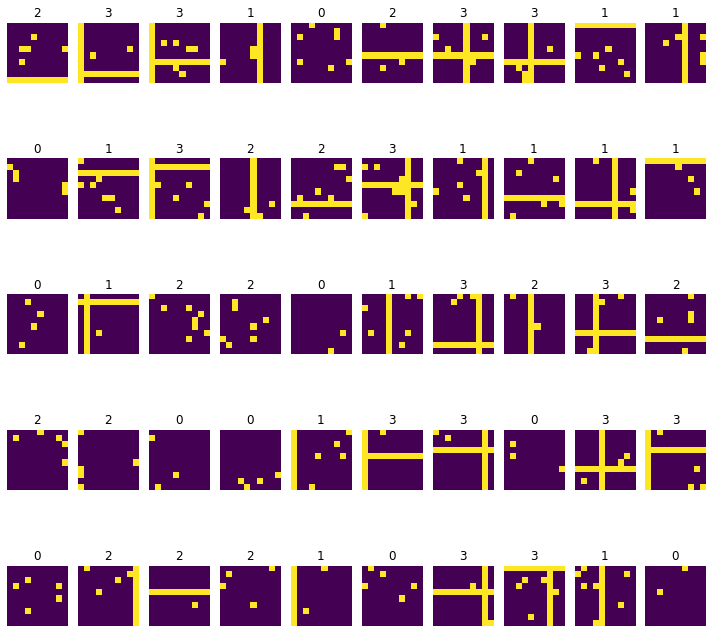

In [6]:
# visualize images from the learned clusters 
# the labels at the top of each image show the label that cfl assigned to the image 
vb_data.viewImages(x_lbls)

# as we can see from these images, class 0 usually corresponds with no bars and 3 usually corresponds with horizontal and vertical bars (both correct), but classes 2 and 1 may contain no bars, vertical bars, and/or horizontal bars. These classes are not being learned as well 

In [4]:
#what probabilities is the CDE predicting for each class? 
noBars = vb_data.getSomeImages(200, 0)
vertBar = vb_data.getSomeImages(200, 1)
horizBar = vb_data.getSomeImages(200, 2)
bothBars = vb_data.getSomeImages(200, 3)
barTypes = [noBars, vertBar, horizBar, bothBars]


import csv 
with open('cde_results2.csv','w', newline='') as csvfile: 
    resultswriter = csv.writer(csvfile, delimiter=' ')
    
    counter =0
    for im_array in barTypes: 
        # for image in im_array: 
        #     image = np.reshape(image, (image.shape[0]*image.shape[1], )) #reshape images for neural net
        x = im_array
        x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 
        probabilities = condExp_object.predict(x, Y=None) #put in the x and y you want to predict with
        
        
        resultswriter.writerow(["class " + str(counter)])
        for result in probabilities: 
            resultswriter.writerow([str(result[0])])
        counter +=1

# view the results in a csv file named cde_results2.csv!!


In [ ]:
# what are the cde results when there's no noise at all? 

### create visual bars data 
sample_size = 1000
im_shape = (10, 10)
noise_lvl= 0.0
set_seed = 143

vb_data_no_noise = vbd.VisualBarsData(n_samples=sample_size, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=set_seed)
x2 = vb_data_no_noise.getImages()
y2 = vb_data_no_noise.getTarget()
    
### reformat x, y into the right shape for the neural net 
y2 = np.expand_dims(y2, -1)
x2 = np.reshape(x2, (x2.shape[0], x2.shape[1]*x2.shape[2])) 
data_info2 = {'X_dims': x2.shape, 'Y_dims': y2.shape} 

#### parameters for CDE 
optimizer_Adam2 = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam2, 'n_epochs': 200, 'test_every': 20, 'save_every': 200}
### generate CDE object (with verbose mode off)
condExp_object2 = condExp.CondExp(data_info2, condExp_params, False)


#### clusterer params 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
#### generate clusterer 
cluster_object2 = kmeans.KMeans(cluster_params)


### put into a cfl core object 
cfl_object_no_noise = tscfl.Two_Step_CFL_Core(condExp_object2, cluster_object2)

x_lbls2, y_lbls2 = cfl_object_no_noise.train(x2, y2)


noBars = vb_data_no_noise.getSomeImages(200, 0)
vertBar = vb_data_no_noise.getSomeImages(200, 1)
horizBar = vb_data_no_noise.getSomeImages(200, 2)
bothBars = vb_data_no_noise.getSomeImages(200, 3)
barTypes = [noBars, vertBar, horizBar, bothBars]


import csv 
with open('cde_results_no_noise.csv','w', newline='') as csvfile: 
    resultswriter = csv.writer(csvfile, delimiter=' ')
    
    
    counter =0
    for im_array in barTypes: 
        # for image in im_array: 
        #     image = np.reshape(image, (image.shape[0]*image.shape[1], )) #reshape images for neural net
        x = im_array
        x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 
        probabilities = condExp_object2.predict(x, Y=None) #put in the x and y you want to predict with
        
        
        resultswriter.writerow(["class " + str(counter)])
        for result in probabilities: 
            resultswriter.writerow([str(result[0])])
        counter +=1

# view the results in a csv file named cde_results_no_noise.csv!!

In [4]:
# what are the cde results with a really, really big sample size? 
# takes like two hours to run this block on my computer 

### create visual bars data 
sample_size = 500000
im_shape = (10, 10)
noise_lvl= 0.05
set_seed = 143

vb_data_big = vbd.VisualBarsData(n_samples=sample_size, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=set_seed)
x3 = vb_data_big.getImages()
y3 = vb_data_big.getTarget()
    
### reformat x, y into the right shape for the neural net 
y3 = np.expand_dims(y3, -1)
x3 = np.reshape(x3, (x3.shape[0], x3.shape[1]*x3.shape[2])) 
data_info3 = {'X_dims': x3.shape, 'Y_dims': y3.shape} 

#### parameters for CDE 
optimizer_Adam3 = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam3, 'n_epochs': 200, 'test_every': 20, 'save_every': 200}
### generate CDE object (with verbose mode off)
condExp_object3 = condExp.CondExp(data_info3, condExp_params, False)


#### clusterer params 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
#### generate clusterer 
cluster_object3 = kmeans.KMeans(cluster_params)


### put into a cfl core object 
cfl_object_big = tscfl.Two_Step_CFL_Core(condExp_object3, cluster_object3)

x_lbls3, y_lbls3 = cfl_object_big.train(x3, y3)


noBars = vb_data_big.getSomeImages(200, 0)
vertBar = vb_data_big.getSomeImages(200, 1)
horizBar = vb_data_big.getSomeImages(200, 2)
bothBars = vb_data_big.getSomeImages(200, 3)
barTypes = [noBars, vertBar, horizBar, bothBars]


import csv 
with open('cde_results_big.csv','w', newline='') as csvfile: 
    resultswriter = csv.writer(csvfile, delimiter=' ')
    
    counter =0
    for im_array in barTypes: 
        # for image in im_array: 
        #     image = np.reshape(image, (image.shape[0]*image.shape[1], )) #reshape images for neural net
        x = im_array
        x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 
        probabilities = condExp_object3.predict(x, Y=None) #put in the x and y you want to predict with
        
        
        resultswriter.writerow(["class " + str(counter)])
        for result in probabilities: 
            resultswriter.writerow([str(result[0])])
        counter +=1

# view the results in a csv file named cde_results_big.csv!!

NameError: name &#39;y&#39; is not defined